# Airbnb analysis: BOSTON

The purpose of this analysis is simple: To understand what affects property price, to discover when property prices are at their highest, to map which areas of the cities are the most expensive, and to see which times of year are busiest for Airbnb hosts in various cities. 

The idea is to make the code in this notebook as reusable as possible, allowing anyone who has the [Airbnb datasets](http://insideairbnb.com/get-the-data.html) to explore the data for any city in the world. 

For the purpose of this exercise, I will be starting with Seattle and Boston.

### Imports

In [9]:
# Data munging
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Read in data

In [10]:
listing = 'Boston/listings.csv'

if '.gz' in listing:
    listings = pd.read_csv(listing, compression='gzip')
else: 
    listings = pd.read_csv(listing)

In [11]:
calendar = 'Boston/calendar.csv'

if '.gz' in calendar:
    calendars = pd.read_csv(calendar, compression='gzip')
else: 
    calendars = pd.read_csv(calendar)

In [12]:
neighborhoods = gpd.read_file('Boston/neighbourhoods.geojson')

## Understanding the data

In [15]:
listings.isna().mean().nlargest(15)

neighbourhood_group_cleansed    1.000000
has_availability                1.000000
license                         1.000000
jurisdiction_names              1.000000
square_feet                     0.984379
monthly_price                   0.752301
weekly_price                    0.751185
security_deposit                0.625662
notes                           0.550907
interaction                     0.433473
access                          0.415342
neighborhood_overview           0.394700
host_about                      0.365132
transit                         0.359833
house_rules                     0.332497
dtype: float64

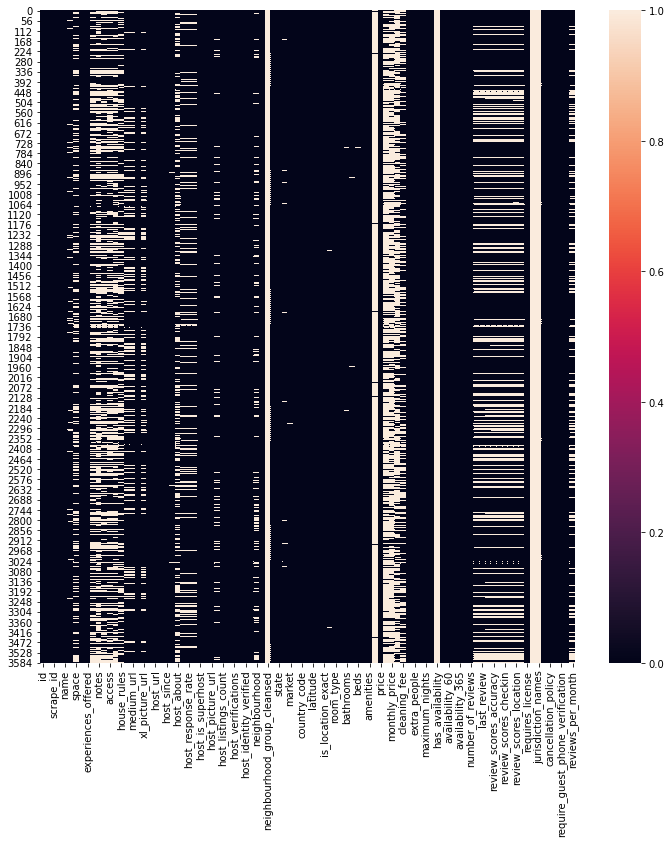

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(boston_listings.isna());

In [16]:
listings.select_dtypes(include=['float', 'int']).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

There are a significant number of values missing in a number of the columns. The data needs to be subset as several of the features are not relevant to the questions I am attempting to answer. For the purpose this analysis, I will only b using the `listings.csv` and `calendar.csv` dataframes. I may attempt to glean insights from the reviews dataset sometime in the future.

## Data prep

The listings and calendar datasets require a lot of cleaning and processing. Various parts of these sets need to formatted fof the by analysis. 

These issues include:

* Missing data
* Unneeded features
* Wrong data types 

The code below deals with these issues.

In [13]:
def clean_data(df):
    
    '''
    INPUT: Pandas dataframe to be cleaned. 
    
    OUTPUT: Pandas dataframe with missing values imputed and unncessary columns dropped
    '''
    
    # Copy dataframe
    df_copy = df.copy()
    
    # Drop columns with all missing values
    df_copy.dropna(axis=1, how='all', inplace=True)
    
    # Fill columns with mean values if they are numerical
    num_col = df_copy.select_dtypes(include=['float', 'int']).columns
    
    for col in num_col:
        df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        

    return df_copy
    
    

In [17]:
boston_listings_clean = clean_data(listings)

In [18]:
def subset_listings_columns(df):
    
    """
    INPUT: Full Airbnb listings dataframe
    OUTPUT: Subset of useful features to use for analysis
    
    """
    
    new_df = df[['id', 'host_since', 'host_is_superhost', 'neighbourhood_cleansed','latitude', 
                         'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
                         'beds', 'price', 'review_scores_rating', 'reviews_per_month', 'availability_30', 'availability_60', 
                         'availability_90', 'availability_365']]
    
    return new_df

In [19]:
boston_subset = subset_listings_columns(boston_listings_clean)

The function in the block below is called in the function after it. `format_prices` can be used with `df.apply()`, while `format_price_col` uses `format_prices` to return a new feature added to the dataset.

In [20]:
def format_prices(value):
    
    """
    Formats price. To be used with df['column'].apply()
    
    INPUT: Can be a dollar value as a string or NaN value
    
    OUTPUT: Stripped figure as a float or NaN value
    """
    
    value = str(value)
    value = value.replace('$', '')
    value = value.replace(',', '')
    
    return float(value)

In [21]:
def format_price_col(df):
    
    """
    Formats prices and returns new formatted_price column
    
    INPUT: Dataframe
    OUTPUT: Applies format_prices to the df and creates 'format_prices' column
    """
    
    df_copy = df.copy()
    
    df_copy['formatted_price'] = df_copy.price.apply(format_prices)
    
    df_copy.drop('price', axis=1, inplace=True)
    
    return df_copy
    

In [22]:
boston_list = format_price_col(boston_subset)

In [25]:
boston_cal = format_price_col(calendars)

In [26]:
def impute_listing_means(df):
    
    """
    Imputes the mean listing price and adds column to dataframe
    
    INPUT: Calendar dataframe 
    OUTPUT: df Mean of the price for each listing
    """
    
    df_copy = df.copy()
    
    listing_means = df_copy[['formatted_price']].fillna(df_copy.groupby('listing_id').transform('mean'))
    
    df_copy['listing_mean_price'] = listing_means['formatted_price']
        
    return df_copy

In [27]:
boston_cal_impute = impute_listing_means(boston_cal)

## Analysis

For this analysis, I won't be applying any form of predictive analysis. However, the end of the project will contain code for cleaning data for later modelling.

### When are the most expensive times of year? 

The first step is to create a datetime index so the dataframe can be organized as a time series. It can then also be resampled by various time periods.

In [28]:
def create_datetime_index(dataframe):
   
    """
    Created a datetime index for the calendar dataframe
    
    INPUT: Takes calendar dataframe
    OUTPUT: Returns dataframe with datetime index
    """
    
    df_copy = dataframe.copy()
    df_copy['date'] = pd.to_datetime(df_copy.date)
    df_copy.index = df_copy.date
    
    return df_copy
    

In [29]:
boston_cal_dt = create_datetime_index(boston_cal_impute)

In [30]:
def plot_price_dates(dataframe, formatted_prices, resample='D'):
   
    """
    Plots the mean listing price over the year
    
    INPUT: Calendar dataframe with datetime index and column in which prices have been formatted, resample rate
    OUTPUT: Plot of mean price by city
    """
    
    dataframe.resample(resample)[formatted_prices].mean().plot(figsize=(10,5))
    plt.title('Mean price per night')
    plt.show();

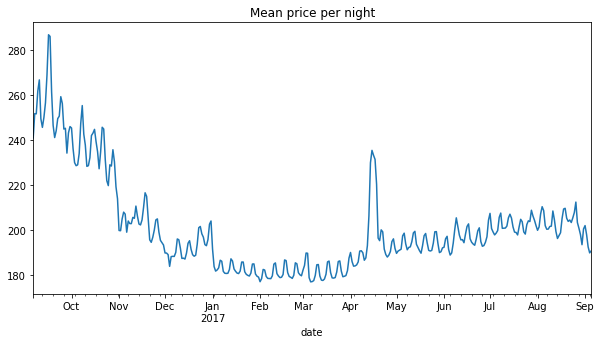

In [31]:
plot_price_dates(boston_cal_dt, 'formatted_price')

### What does the availability of properties look like throughout the year? 

To solve this problem, neighborhood information needs to be merged with the calendar dataframe. The `plot_availability` function below can also take a rate of availability, allowing you to test various availability rates. By default it is set to 50%. 

In [32]:
def merge_neighborhood_to_calendar(calendar_df, listing_df):
    
    """
    Merges neighborhood names to calendar dataframe
    
    INPUT: Dataframe with listings
           Dataframe with booking dates
           
    OUTPUT: Returns calendar df with neighborhood details and available values mapped to booleans
    
    """
    
    neighborhood_id = listing_df[['id', 'neighbourhood_cleansed']]
    new_df = calendar_df.merge(neighborhood_id, left_on='listing_id', right_on='id')
    new_df.drop('id', axis=1, inplace=True)
   
    return new_df
    

In [33]:
boston_cal = merge_neighborhood_to_calendar(boston_cal_dt, boston_list)

In [34]:
def plot_availability(df, availability):
   
    """
    INPUT: Takes a calendar dataframe with datetime index
           Availability is the mean availability rate for a month in the year (float)
    
           
    OUTPUT: Returns a grid of heatmaps showing availabity of each neighborhood in a given city
    
    Note: This can take a while to run if there are a lot of neighborhoods
    
    """
    # Get a list of the neighborhoods in the dataset
    neighborhoods = df['neighbourhood_cleansed'].unique()
    
    # Create boolean values for availability
    df['available_formatted'] = df['available'].map({'t': True, 'f': False})
    
    df.index = df.date
   
    # Set up subplots with the number of rows equal to the number of neighborhoods in a city
    fig, axes = plt.subplots(len(neighborhoods), 1, sharex=True, sharey=False, figsize=(10, len(neighborhoods)))
    
    # Create x-axis ticks
    labels = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
         'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan']    
    
    # Loop through neighborhoods to plot availability
    for count, neighborhood in enumerate(neighborhoods):
        
        # Subset neighborhood
        data = df[df.neighbourhood_cleansed == neighborhood].resample('M')['available_formatted'].mean() > availability
        
        # Reshape and transpose
        data = np.asarray(data).reshape(13,1)
        data = np.transpose(data)
        
        # Plot
        ax = plt.subplot(len(neighborhoods), 1, count + 1)
        sns.heatmap(data, cbar=False, xticklabels=labels, yticklabels=False)
        ax.set_title(neighborhood)
        ax.xaxis.tick_top()
        plt.subplots_adjust(hspace=2)


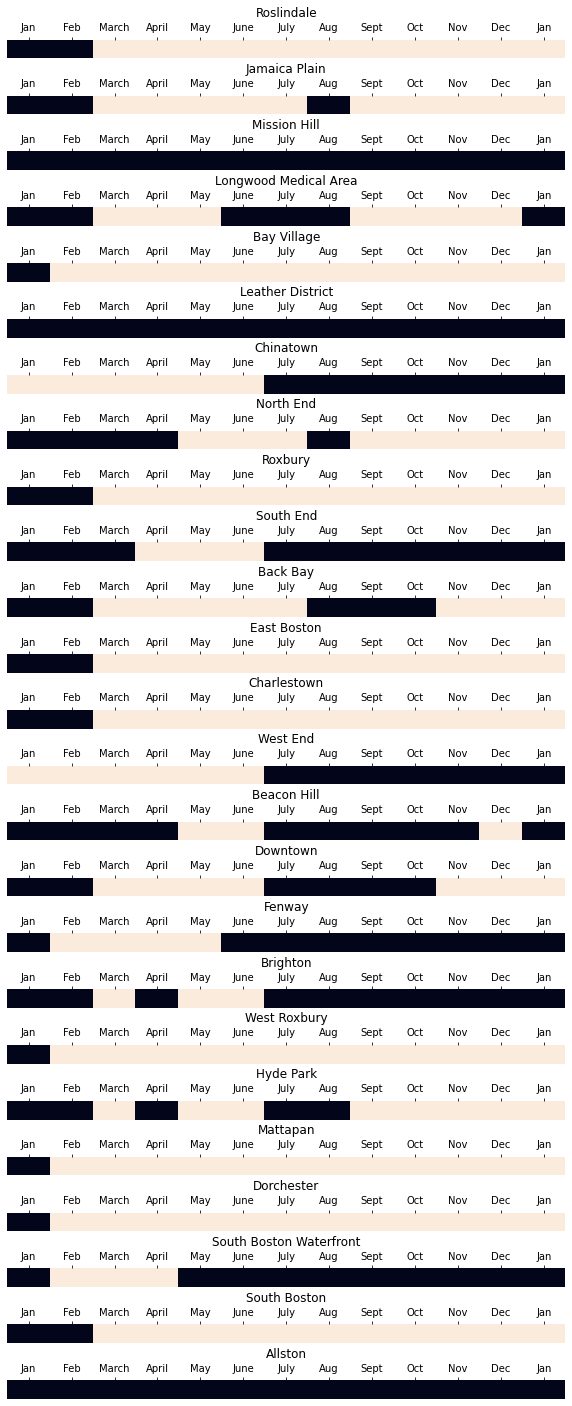

In [34]:
plot_availability(boston_cal, 0.5)

### Which nighborhoods are most expensive?

To anwser this question, we need to calculate the mean price by neighborhood and then display the highest values. This data is then mapped in a chloropleth map.

In [35]:
def neighborhood_means(df):
    
    """
    Calculates the mean listing price for each neighborhood
    
    INPUT: listing dataframe
    OUTPUT: Dataframs with neighborhood and the mean price for each neighborhood
    """
    
    df_copy = df.copy()
    
    if 'price' in df_copy.columns:
    
        df_copy['formatted_price'] = df_copy['price'].apply(format_prices)
    else:
        pass
    
    return pd.DataFrame(df_copy.groupby('neighbourhood_cleansed')['formatted_price'].mean()).reset_index()
    

In [36]:
neigh_means = neighborhood_means(boston_list)

In [37]:
neigh_means.sort_values('formatted_price', ascending=False)

,neighbourhood_cleansed,formatted_price
21,South Boston Waterfront,306.060241
2,Bay Village,266.833333
13,Leather District,253.600000
1,Back Bay,240.950331
8,Downtown,236.459302
6,Chinatown,232.352113
3,Beacon Hill,224.443299
10,Fenway,220.393103
23,West End,209.591837
22,South End,204.349693


In [44]:
def map_means(df, neighborhoods_df):
    
    """
    Maps the man price of listigs by neighbourhood
    
    INPUT: Dataframe and geopandas dataframe with neighbourhood data
    OUTPUT: Chloropleth map with neighborhood means
    
    """
    # Make copies of inpute datasets
    df_copy = df.copy()
    geo_copy = neighborhoods_df.copy()
    
    # Create a dataframe of neighborhoods and their mean prices
    neighborhood_mean = neighborhood_means(df_copy)
    
    # Merge the geodataframe with the mean prices dataframe
    merged = geo_copy.merge(neighborhood_mean, left_on='neighbourhood', right_on='neighbourhood_cleansed')
    
    # Drop unnecessary columns
    merged.drop(['neighbourhood_group', 'neighbourhood_cleansed'], axis=1, inplace=True)
    
    # Set up min and max values for the colorbar
    vmin = merged['formatted_price'].min()
    vmax = merged['formatted_price'].max() 
    
    # Set up figure
    fig, ax = plt.subplots(1, figsize=(15,10))

    # Plot figure
    merged.plot(column='formatted_price', cmap='YlOrRd', ax=ax)
    
    # Plot colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm)
    cbar.outline.set_visible(False) 
    
    # Remove axes and show figure
    ax.axis('off');
    
    plt.savefig('boston.png', bbox_inches='tight')

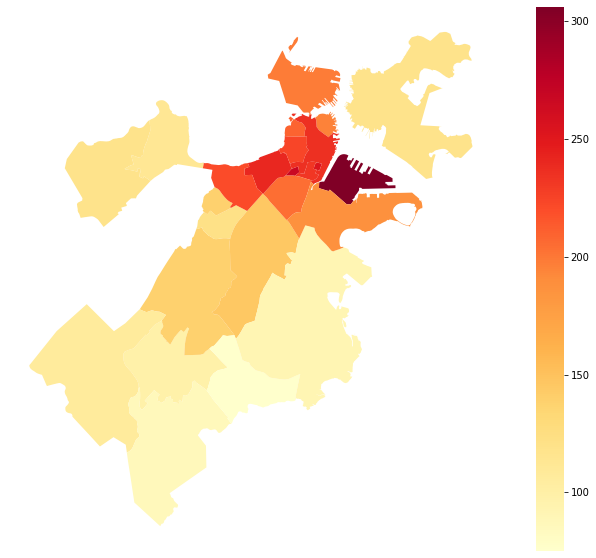

In [45]:
map_means(neigh_means, neighborhoods)

### Where do various types of properties predominate? 

The function below can display features of the dataset according to where each property is located. By default, it takes the property type. 

In [40]:
def plot_locations(df, neighborhoods, color_by='property_type'):
    
    
    """
    Plots the locations of Airbnb listings, colored by a feature of the dataframe
    
    INPUT: Listing dataframe, neighborhoods df, color_by
    OUTPUT: Plot of listing locations colored by another column
    
    """
    
    # Create dataframe with geometry column 
    geo_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    
    # Set up plot
    ax = neighborhoods.plot(figsize=(30,10), facecolor='#C1C1C1', edgecolor='white')
    geo_data.plot(ax=ax, markersize=12, alpha=0.5, column=color_by, cmap='Accent', legend=True)
    ax.axis('off')
    plt.show()

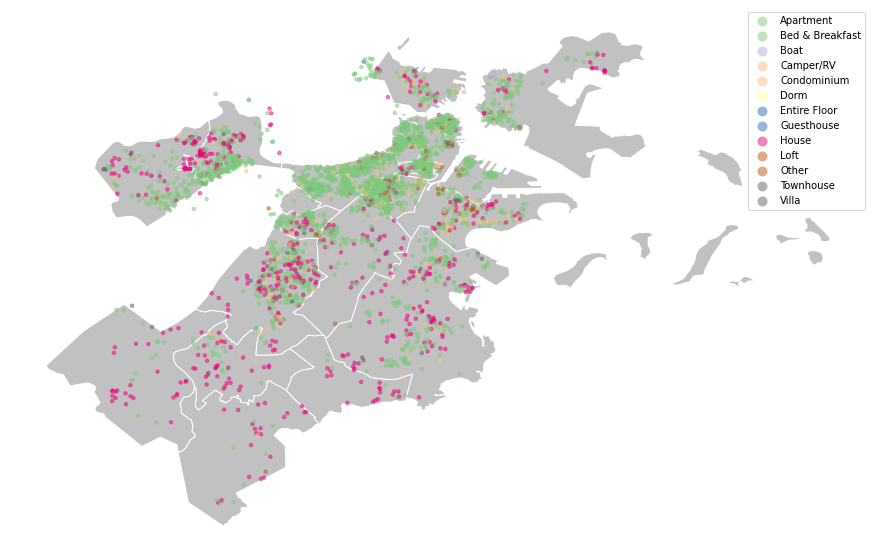

In [42]:
plot_locations(boston_list, neighborhoods)

### Which features are most highly correlated with the price of a listing? 

In [11]:
def map_neigh_to_num(df):
    
    """
    Maps the name of a neighborhood to a number
    
    INPUT: Listing dataframe
    OUTPUT: neighbourhood_group_cleansed column mapped to number
    
    """
    
    neigh_list = list(df['neighbourhood_group'].unique())
    
    num_dict = dict(zip(neigh_list, len(neigh_list)))
    
    return num_dict

In [43]:
bos_list = format_price_col(boston_listings)

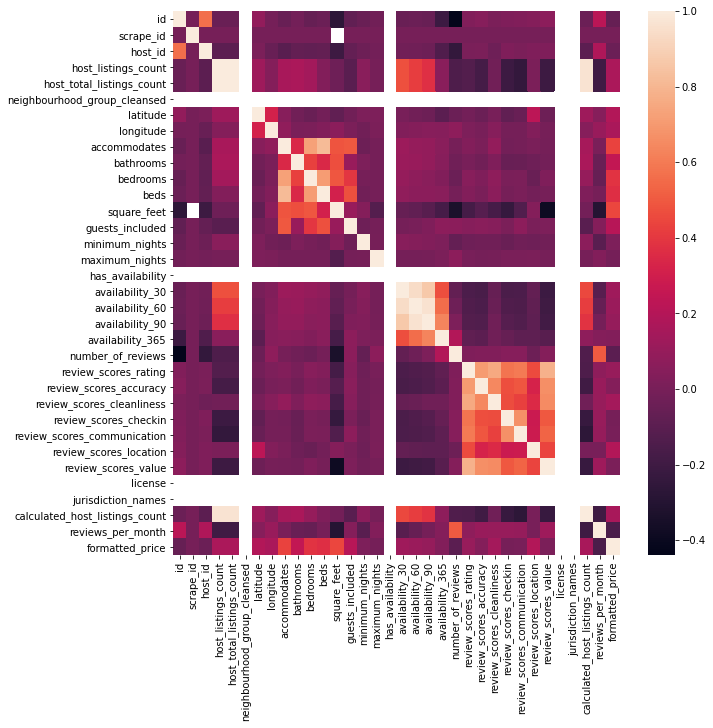

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(bos_list.corr());

In [46]:
def price_corr(df):
    
    """
    INPUT: Pandas listing dataframe
    OUTPUT: Correlation table
    
    """
    
    corr = df.corr()
    corr = corr.sort_values('formatted_price', ascending=False)['formatted_price']
    corr = corr.reset_index()
    corr.columns = ['feature', 'correlation']
    
    return corr.style.bar(subset=['correlation'], color=['#d65f5f', '#5fba7d'], align='zero')

In [47]:
price_corr(bos_list)

,feature,correlation
0,formatted_price,1.000000
1,square_feet,0.447795
2,accommodates,0.437756
3,bedrooms,0.385298
4,beds,0.370013
5,bathrooms,0.248234
6,guests_included,0.211806
7,latitude,0.196270
8,review_scores_location,0.193928
9,host_listings_count,0.171930


### Which features are most highly correlated with the review of a listing? 

In [48]:
def review_corr(df):
    
    """
    INPUT: Pandas listing dataframe
    OUTPUT: Correlation table
    
    """
    
    corr = df.corr()
    corr = corr.sort_values('review_scores_rating', ascending=False)['review_scores_rating']
    corr = corr.reset_index()
    corr.columns = ['feature', 'correlation']
    
    return corr.style.bar(subset=['correlation'], color=['#d65f5f', '#5fba7d'], align='zero')

In [50]:
review_corr(bos_list)

,feature,correlation
0,review_scores_rating,1.000000
1,review_scores_value,0.786320
2,review_scores_cleanliness,0.754327
3,review_scores_accuracy,0.705104
4,review_scores_communication,0.600599
5,review_scores_checkin,0.584034
6,review_scores_location,0.458901
7,formatted_price,0.105651
8,reviews_per_month,0.076976
9,bedrooms,0.055272


## Publishing the results

Apart from this repository, a blog post detailing the process of this analysis can be found [here]().

## The next step

The code below forms the next step of the process for the analysis, although I've decided that it is slightly outside the scope of the project. I may come back to it at later date. 

In [132]:
def clean_for_modelling(df):
    
    """
    INPUT: Listings dataframe
    OUTPUT: X and y sets [drop unneeded columns, fill null values, create categorical dummy variables]
    
    """
    
    df_copy = df.copy()
    
    # Drop date column
    df_copy.drop(['id','host_since', 'latitude', 'longitude', 'geometry'], axis=1, inplace=True)
    
    # Format amount column
    if 'price' in df_copy.columns:
        
        df_copy['formatted_price'] = df_copy.price.apply(format_prices)
        df_copy.drop('price', axis=1, inplace=True)
    
    else:
        pass
    
    # Create list of categorical columns
    cat_cols = df_copy.select_dtypes(include=['object']).columns
    
    # Fill null values in categorical columns
    for col in cat_cols:
        df_copy[col].fillna(df_copy[col].value_counts()[0], inplace=True)
        
    # create list of numerical features
    num_cols = df_copy.select_dtypes(include=['float', 'int']).columns
    
     # Create list of neighborhoods
    neighborhoods = list(df_copy['neighbourhood_cleansed'].unique())
    
    # Fill numerical columns based on neighborhood mean
    for col in num_cols:
        for neighborhood in neighborhoods:
            df_copy[col].fillna(df_copy[df_copy.neighbourhood_cleansed == neighborhood][col].mean(), inplace=True)
    
    # Create X and y sets
    X = df_copy.drop('formatted_price', axis=1)
    y = df_copy['formatted_price']
    
    for col in cat_cols:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True, 
                                                          dummy_na=False)], axis=1)
        
    return X, y

In [133]:
X, y = clean_for_modelling(boston_list)

In [141]:
def split_and_scale(X, y):
    
    """
    Takes X and y sets and splits. Assign as X_train, X_test, y_train, y_test
    
    INPUT: X, y sets
    OUTPUT: Scaled X_train, X_test, and y_train and y_test sets
    """
    
    # Split in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Instantiate scaler and fit
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    # Transform X_train, X_test
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [142]:
X_train, X_test, y_train, y_test = split_and_scale(X, y)